# Some basic plots with matplotlib and pandas

Pandas is an open source Python library for data analysis. It introduces two new data structures to Python - Series and DataFrame, both of which are built on top of NumPy (this means it's fast).
- [Series](http://pandas.pydata.org/pandas-docs/version/0.15.2/dsintro.html#basicsseries) is a one-dimensional labeled array capable of holding any data type (integers, strings, floating point numbers, Python objects, etc.). 
- [DataFrame](http://pandas.pydata.org/pandas-docs/version/0.15.2/dsintro.html#basics-dataframe) is a 2-dimensional labeled data structure with columns of potentially different types. You can think of it like a spreadsheet or SQL table, or a dict of Series objects.

Pandas is also tightly integrated with [matplotlib](http://pandas.pydata.org/pandas-docs/version/0.15.2/visualization.html) and you do basic plotting directly from a dataframe.

For this exercise we will use downscaled climate projections for maximum temperature and precipitation from the [Cal-Adapt API](http://beta.cal-adapt.org/)

In [1]:
# A 'magic' command that displays plots inline inside the notebook as static images
%matplotlib inline

try:
    import requests 
    import json
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
except ImportError:
    print('Some required Python modules are missing.')
    
# Setting headers for HTTP request, Cal-Adapt API provides data in json, csv, geotiff formats. We will use json.
headers = {'ContentType': 'json'}

# entry point of the API
api = 'http://api.cal-adapt.org/api'

### Let's look at data for Sacramento County

If you open [this link](http://api.cal-adapt.org/api/), you can see a list of resources currently available through the api. The list of climate datasets is under `series`. You can pass in your own geometry to query the climate data or use geometry available through the api. For this exercise we will use the `counties` resource available through the Cal-Adapt api. 

The code below gets the `id` for the polygon feature (Sacramento County) by querying the `counties` resource.

In [2]:
feature_resource = 'counties'
feature = None

# Point location (within Sacramento County) in geojson format
lat = 38.5938
lng = -121.4687
point = '{"type":"Point","coordinates":[' + str(lng) + ',' + str(lat) + ']}'

# Params
params = {'intersects': point, 'srs': 4326, 'precision': 4}
params_str = "&".join("%s=%s" % (k,v) for k,v in params.items())

# Construct url
url = api + '/' + feature_resource + '/' + '?' + params_str
print(url)
print()

# Get county geometry from api
# Construct a uri string which we will pass to the api later
try:
    response = requests.get(url, headers=headers)
    json = response.json()
    feature = json['features'][0]
    print(feature)
except requests.exceptions.HTTPError as err:
    print (err)

http://api.cal-adapt.org/api/counties/?intersects={"type":"Point","coordinates":[-121.4687,38.5938]}&srs=4326&precision=4

{'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[-121.5216290001256, 38.73641094745772], [-121.506266022973, 38.73575192290427], [-121.4903329386042, 38.73504292413254], [-121.4900559911822, 38.73500398101285], [-121.4894260486141, 38.73496403506602], [-121.4843870094908, 38.73460301730404], [-121.4741010117545, 38.73390204114949], [-121.4737401611298, 38.73387797329858], [-121.473276019313, 38.73384705279582], [-121.4723229992763, 38.73378805313378], [-121.4701089241405, 38.73363194637926], [-121.4698279654092, 38.73361305980192], [-121.4666160772928, 38.73339594773124], [-121.4576150353678, 38.73290807233888], [-121.4513829662508, 38.73249708035887], [-121.4478949664006, 38.73224704213105], [-121.4415719742922, 38.73179493423933], [-121.4390400029601, 38.73161693242604], [-121.4335979944727, 38.73124404787649], [-121.4296550453884, 38.73097696158779], [-1

### Get Maximum Temperature & Precipitation data for HadGEM2-ES model for RCP 8.5 scenario

Url's for resources are hardcoded below, if you want to explore how to get other climate data check out these [Jupyter Notebooks](https://github.com/berkeley-gif/caladapt-public)

In [3]:
temp_url = 'http://api.cal-adapt.org/api/series/tasmax_year_HadGEM2-ES_rcp85/'
pr_url = 'http://api.cal-adapt.org/api/series/pr_year_HadGEM2-ES_rcp85/'

Setup parameters for requesting data

In [4]:
# One way to pass in geometry to Cal-Adapt api is to use the ref parameter
ref = '/api/' + feature_resource + '/' + str(feature['id']) + '/'
print ('Uniform Resource Identifier for county: ' + ref)

# Another way to pass in geometry is to use the g param with spatial boundary in geojson/WKT format.
# For this exercise we will not use this param
g = feature['geometry']

Uniform Resource Identifier for county: /api/counties/34/


In [5]:
# Period
#startYear = 1961
#endYear = 1990
#period = str(startYear) + '-01-01/' + str(endYear) + '-12-31'

# Alternatively get complete timeseries (2006 - 2099) and filter dates later on
period = 'rasters'

In [6]:
# Pagesize - number of records returned, default is 10
pagesize = 100

The downscaled climate model data in Cal-Adapt has a resolution of aproximately 6 km. So within a county there are multiple 6 km x 6 km grid cells. For this exercise, we don't want the value for each grid cell, we want the mean value for the county. To do this spatial aggregation you can pass a `stat` parameter.

In [7]:
# Spatial aggregation
stat = 'mean'

In [8]:
# Create params string to pass to api
params = {'pagesize': pagesize, 'ref': ref, 'stat': stat}
params_str = "&".join("%s=%s" % (k,v) for k,v in params.items())

Make request for temperature data

In [9]:
# Construct request
url = temp_url +  period + '/?' + params_str

# Variable to store data
temp_data = None
    
try:
    response = requests.get(url, headers=headers)
    json = response.json()
    temp_data = json['results']
    print(temp_data[0])
except requests.exceptions.HTTPError as err:
    print (err)

{'id': 12320, 'tileurl': 'http://api.cal-adapt.org/tiles/tasmax_year_HadGEM2-ES_rcp85_2006/{z}/{x}/{y}.png', 'url': 'http://api.cal-adapt.org/api/rstores/tasmax_year_HadGEM2-ES_rcp85_2006/', 'image': 297.00596005154637, 'width': 179, 'height': 195, 'geom': {'type': 'Polygon', 'coordinates': [[[-124.5625, 31.5625], [-113.375, 31.5625], [-113.375, 43.75], [-124.5625, 43.75], [-124.5625, 31.5625]]]}, 'event': '2006-01-01', 'srs': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]', 'minval': 277.29461669921875, 'maxval': 306.6802673339844, 'nodata': 1.0000000150474662e+30, 'xpixsize': 0.0625, 'ypixsize': -0.0625, 'name': 'yearly average maximum temperature HadGEM2-ES RCP 8.5', 'slug': 'tasmax_year_HadGEM2-ES_rcp85_2006', 'units': 'K'}


Make request for precipitation data

In [10]:
# Construct request
url = pr_url +  period + '/?' + params_str

# Variable to store data
pr_data = None
    
try:
    response = requests.get(url, headers=headers)
    json = response.json()
    pr_data = json['results']
    print(pr_data[0])
except requests.exceptions.HTTPError as err:
    print (err)
    sys.exit(1)

{'id': 12132, 'tileurl': 'http://api.cal-adapt.org/tiles/pr_year_HadGEM2-ES_rcp85_2006/{z}/{x}/{y}.png', 'url': 'http://api.cal-adapt.org/api/rstores/pr_year_HadGEM2-ES_rcp85_2006/', 'image': 6.969961140919285e-06, 'width': 179, 'height': 195, 'geom': {'type': 'Polygon', 'coordinates': [[[-124.5625, 31.5625], [-113.375, 31.5625], [-113.375, 43.75], [-124.5625, 43.75], [-124.5625, 31.5625]]]}, 'event': '2006-01-01', 'srs': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]', 'minval': 4.3958837636637327e-07, 'maxval': 0.00010573217878118157, 'nodata': 1.0000000150474662e+30, 'xpixsize': 0.0625, 'ypixsize': -0.0625, 'name': 'yearly average precipitation HadGEM2-ES RCP 8.5', 'slug': 'pr_year_HadGEM2-ES_rcp85_2006', 'units': 'kg/m2/s'}


### Create pandas dataframe from data.

Create pandas dataframe from Tmax data

In [11]:
# Create dataframe
dfT = pd.DataFrame(temp_data)

# Change format of `event` field from string to datetime
dfT['event'] = pd.to_datetime(dfT['event'], format='%Y-%m-%d')

# Set event field as index
dfT = dfT.set_index(['event'])

# image field holds the data values
# Convert temperature units from Kelvin to degrees Fahrenheit
dfT['image'] = dfT['image'].apply(lambda x: (x - 273.15) * 9 / 5 + 32)

# Print first 5 rows
dfT.head()

,geom,height,id,image,maxval,minval,name,nodata,slug,srs,tileurl,units,url,width,xpixsize,ypixsize
event,,,,,,,,,,,,,,,,
2006-01-01,"{'type': 'Polygon', 'coordinates': [[[-124.562...",195,12320,74.940728,306.680267,277.294617,yearly average maximum temperature HadGEM2-ES ...,1.000000e+30,tasmax_year_HadGEM2-ES_rcp85_2006,"GEOGCS[""WGS 84"",DATUM[""WGS_1984"",SPHEROID[""WGS...",http://api.cal-adapt.org/tiles/tasmax_year_Had...,K,http://api.cal-adapt.org/api/rstores/tasmax_ye...,179,0.0625,-0.0625
2007-01-01,"{'type': 'Polygon', 'coordinates': [[[-124.562...",195,12321,78.062277,306.515289,279.461761,yearly average maximum temperature HadGEM2-ES ...,1.000000e+30,tasmax_year_HadGEM2-ES_rcp85_2007,"GEOGCS[""WGS 84"",DATUM[""WGS_1984"",SPHEROID[""WGS...",http://api.cal-adapt.org/tiles/tasmax_year_Had...,K,http://api.cal-adapt.org/api/rstores/tasmax_ye...,179,0.0625,-0.0625
2008-01-01,"{'type': 'Polygon', 'coordinates': [[[-124.562...",195,12322,75.513884,306.392303,277.135956,yearly average maximum temperature HadGEM2-ES ...,1.000000e+30,tasmax_year_HadGEM2-ES_rcp85_2008,"GEOGCS[""WGS 84"",DATUM[""WGS_1984"",SPHEROID[""WGS...",http://api.cal-adapt.org/tiles/tasmax_year_Had...,K,http://api.cal-adapt.org/api/rstores/tasmax_ye...,179,0.0625,-0.0625
2009-01-01,"{'type': 'Polygon', 'coordinates': [[[-124.562...",195,12323,75.522800,306.001038,277.822418,yearly average maximum temperature HadGEM2-ES ...,1.000000e+30,tasmax_year_HadGEM2-ES_rcp85_2009,"GEOGCS[""WGS 84"",DATUM[""WGS_1984"",SPHEROID[""WGS...",http://api.cal-adapt.org/tiles/tasmax_year_Had...,K,http://api.cal-adapt.org/api/rstores/tasmax_ye...,179,0.0625,-0.0625
2010-01-01,"{'type': 'Polygon', 'coordinates': [[[-124.562...",195,12324,74.213936,305.385651,277.153900,yearly average maximum temperature HadGEM2-ES ...,1.000000e+30,tasmax_year_HadGEM2-ES_rcp85_2010,"GEOGCS[""WGS 84"",DATUM[""WGS_1984"",SPHEROID[""WGS...",http://api.cal-adapt.org/tiles/tasmax_year_Had...,K,http://api.cal-adapt.org/api/rstores/tasmax_ye...,179,0.0625,-0.0625


Create pandas dataframe from Precip data

In [12]:
# Create dataframe
dfP = pd.DataFrame(pr_data)

# Change format of `event` field from string to datetime
dfP['event'] = pd.to_datetime(dfP['event'], format='%Y-%m-%d')

# Set event field as index
dfP = dfP.set_index(['event'])

# Precipitation units for modeled data are in kg/m2/s
# convert into inches/day (TODO: update conversion for leap years)
dfP['image'] = dfP['image'].apply(lambda x: x * 86400 * 0.0393701 * 365)

# Print first 5 rows
dfP.head()

,geom,height,id,image,maxval,minval,name,nodata,slug,srs,tileurl,units,url,width,xpixsize,ypixsize
event,,,,,,,,,,,,,,,,
2006-01-01,"{'type': 'Polygon', 'coordinates': [[[-124.562...",195,12132,8.653733,0.000106,4.395884e-07,yearly average precipitation HadGEM2-ES RCP 8.5,1.000000e+30,pr_year_HadGEM2-ES_rcp85_2006,"GEOGCS[""WGS 84"",DATUM[""WGS_1984"",SPHEROID[""WGS...",http://api.cal-adapt.org/tiles/pr_year_HadGEM2...,kg/m2/s,http://api.cal-adapt.org/api/rstores/pr_year_H...,179,0.0625,-0.0625
2007-01-01,"{'type': 'Polygon', 'coordinates': [[[-124.562...",195,12133,8.231723,0.000052,4.728979e-07,yearly average precipitation HadGEM2-ES RCP 8.5,1.000000e+30,pr_year_HadGEM2-ES_rcp85_2007,"GEOGCS[""WGS 84"",DATUM[""WGS_1984"",SPHEROID[""WGS...",http://api.cal-adapt.org/tiles/pr_year_HadGEM2...,kg/m2/s,http://api.cal-adapt.org/api/rstores/pr_year_H...,179,0.0625,-0.0625
2008-01-01,"{'type': 'Polygon', 'coordinates': [[[-124.562...",195,12134,13.949712,0.000117,3.954958e-07,yearly average precipitation HadGEM2-ES RCP 8.5,1.000000e+30,pr_year_HadGEM2-ES_rcp85_2008,"GEOGCS[""WGS 84"",DATUM[""WGS_1984"",SPHEROID[""WGS...",http://api.cal-adapt.org/tiles/pr_year_HadGEM2...,kg/m2/s,http://api.cal-adapt.org/api/rstores/pr_year_H...,179,0.0625,-0.0625
2009-01-01,"{'type': 'Polygon', 'coordinates': [[[-124.562...",195,12135,20.149283,0.000134,1.600838e-06,yearly average precipitation HadGEM2-ES RCP 8.5,1.000000e+30,pr_year_HadGEM2-ES_rcp85_2009,"GEOGCS[""WGS 84"",DATUM[""WGS_1984"",SPHEROID[""WGS...",http://api.cal-adapt.org/tiles/pr_year_HadGEM2...,kg/m2/s,http://api.cal-adapt.org/api/rstores/pr_year_H...,179,0.0625,-0.0625
2010-01-01,"{'type': 'Polygon', 'coordinates': [[[-124.562...",195,12136,31.567442,0.000189,1.611246e-06,yearly average precipitation HadGEM2-ES RCP 8.5,1.000000e+30,pr_year_HadGEM2-ES_rcp85_2010,"GEOGCS[""WGS 84"",DATUM[""WGS_1984"",SPHEROID[""WGS...",http://api.cal-adapt.org/tiles/pr_year_HadGEM2...,kg/m2/s,http://api.cal-adapt.org/api/rstores/pr_year_H...,179,0.0625,-0.0625


### Basic line chart

The plot method on DataFrame is just a simple wrapper around a matplotlib method - plt.plot()

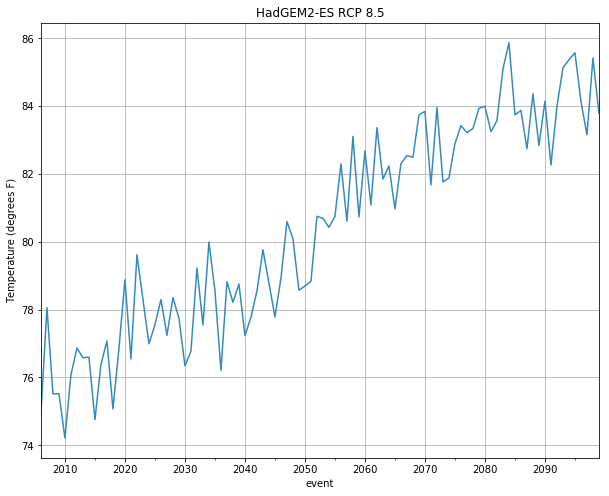

In [13]:
dfT['image'].plot(figsize=(10, 8), color='#348ABD')
plt.title("HadGEM2-ES RCP 8.5")
plt.ylabel("Temperature (degrees F)")
plt.grid(True)

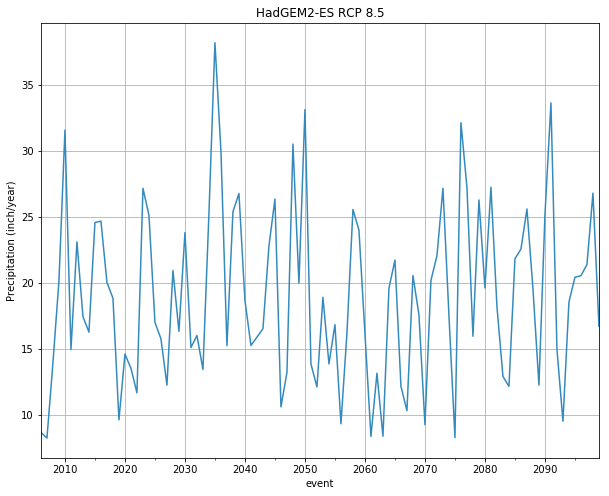

In [14]:
dfP['image'].plot(figsize=(10, 8), color='#348ABD')
plt.title("HadGEM2-ES RCP 8.5")
plt.ylabel("Precipitation (inch/year)")
plt.grid(True)

### A quick histogram

Many many different way to do the same thing ...

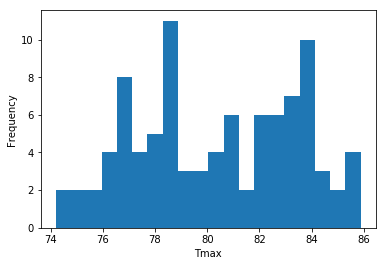

In [15]:
dfT['image'].plot.hist(bins=20)
plt.xlabel('Tmax')

Introducing [seaborn](http://seaborn.pydata.org/index.html). Seaborn is a Python visualization library based on matplotlib. It provides a high-level interface for drawing attractive statistical graphics.

/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


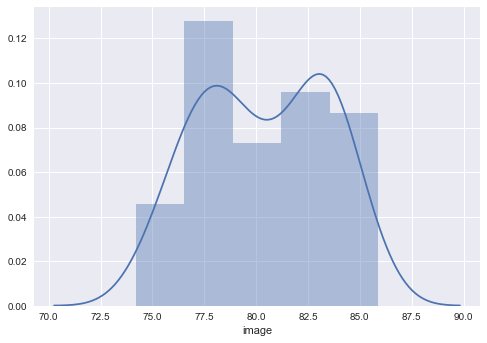

In [16]:
import seaborn as sns

sns.distplot(dfT['image'])
sns.plt.show()

### A quick boxplot

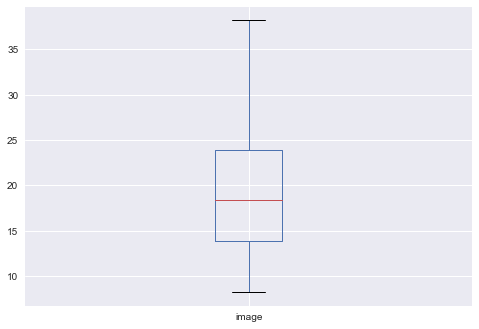

In [17]:
dfP['image'].plot.box()

### Scatterplot

In this example we will use matplot lib directly and pass in the dataframe.

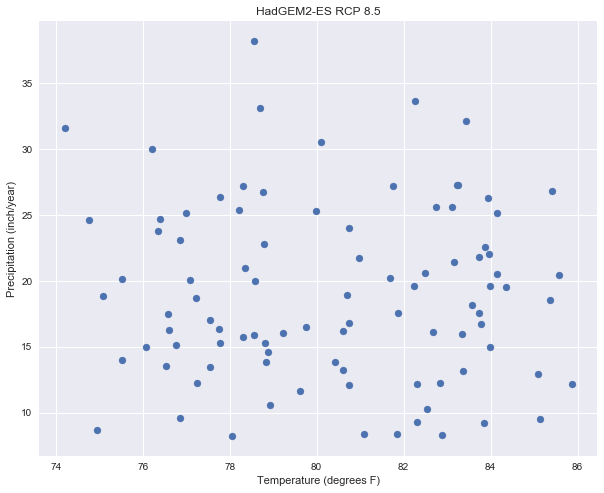

In [18]:
plt.figure(figsize=(10,8)) 
plt.scatter(dfT['image'], dfP['image'])
plt.title("HadGEM2-ES RCP 8.5")
plt.ylabel("Precipitation (inch/year)")
plt.xlabel("Temperature (degrees F)")
plt.grid(True)

Let's use different color for different time periods (2006-2050 and 2051 -2099). One way to do this is to add a new column to each dataframe with the color. Might be better to construct a new dataframe with temperature and precipitation values.

In [19]:
dfT['color'] = np.where(dfT.index.year >= 2050, 'red', 'blue')
dfP['color'] = np.where(dfP.index.year >= 2050, 'red', 'blue')

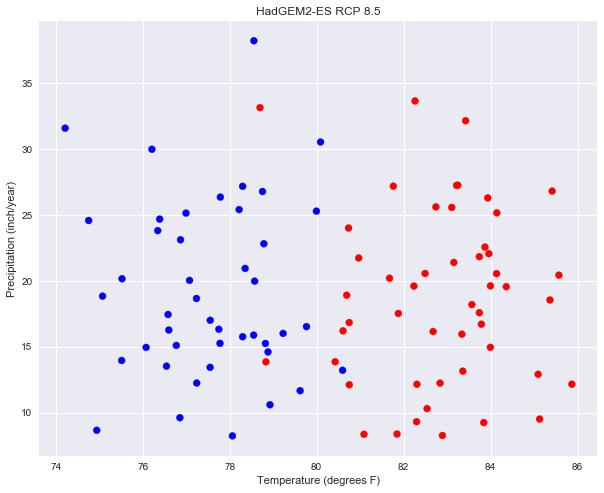

In [20]:
plt.figure(figsize=(10,8)) 
plt.scatter(dfT['image'], dfP['image'], color=dfT['color'])
plt.title("HadGEM2-ES RCP 8.5")
plt.ylabel("Precipitation (inch/year)")
plt.xlabel("Temperature (degrees F)")
plt.grid(True)

Experiment with more examples [here]( http://pandas.pydata.org/pandas-docs/stable/visualization.html)